# Decision Trees and Ensemble Learning
This week, we'll talk about decision trees and tree-based ensemble algorithms

# Credit risk scoring project
Dataset: https://github.com/gastonstat/CreditScoring

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(legacy='1.25')

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.1 Data cleaning and preparation
* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv(data)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

Categorical variables are represented by numbers. For converting, we'll use the following map (extracted from Part1_CredScoring_Processing.R). It's code in R which we'll translate to Pandas.

levels(dd$Status) = c("good", "bad")   

levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")  

levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")  

levels(dd$Records) = c("no_rec", "yes_rec")  

levels(dd$Job) = c("fixed", "partime", "freelance", "others")  

Let's convert it:

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


After this, all the categorical variables have strings, not numbers

Let's look at numerical variables:

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


99999999 indicate missing values. Let's replace it by NaN:

In [12]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [13]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

Now the stats are more meaninful

In [14]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Let's look at the target variable

There's one record for which the status is unknown. Let's remove it - it's not useful for us

In [15]:
df = df[df.status != 'unk'].reset_index(drop=True)

Now we're ready to prepare the data for training:

First, do train-validation-test split

Then, apply one-hot encoding to categorical features and get the feature matrix

In [16]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [19]:
del df_train['status']
del df_val['status']
del df_test['status']

In [20]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [21]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


For OHE, we'll use DictVectorizer

In [22]:
from sklearn.feature_extraction import DictVectorizer

Remember that we have some missing values:

In [23]:
df_train.isnull().sum()

seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       25
assets       30
debt         11
amount        0
price         0
dtype: int64

We'll replace them with "0" like in Chapter 2

In [24]:
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

In [25]:
dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [26]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

Now we're ready to train a model. We'll start with decision trees

## 6.2 Decision Trees
* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [27]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [28]:
assess_risk(dict_train[0])

'ok'

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

Let's fit the tree with default parameters

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6650117459010438

In [32]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

That's a case of overfitting - our model on the training data performs perfectly, but fails on validation

Let's change the depth parameter: restring the size of the tree to 2 levels:

In [33]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [34]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [35]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## 6.3 Decision tree learning algorithm
* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [36]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [37]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [38]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [39]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [40]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



The best split is at T = 3000 with Impurity = 10% (0% left + 20% right)

Let's now add another feature ('debt'):

In [41]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [42]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [43]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [44]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


The best split is still at T = 3000 for assets

**Stopping criteria:**
* Group already pure
* Depth limit reached
* Group too small to be splitted

**DT Learning algorithm:**
* Find the best split
* Stop if max depth is reached
* If Left is sufficiently large and not pure: repeat for Left
* If Right is sufficiently large and not pure: repeat for Right

Of course this is a simplified view. For more info see the [Scikit-learn DT doc](https://scikit-learn.org/1.5/modules/tree.html)

## 6.4 Decision trees parameter tuning
* selecting max_depth
* selecting min_samples_leaf

In [45]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.762
  10 -> 0.689
  15 -> 0.678
  20 -> 0.658
None -> 0.656


In [46]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [47]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [48]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.750
5                 0.761  0.768  0.759
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

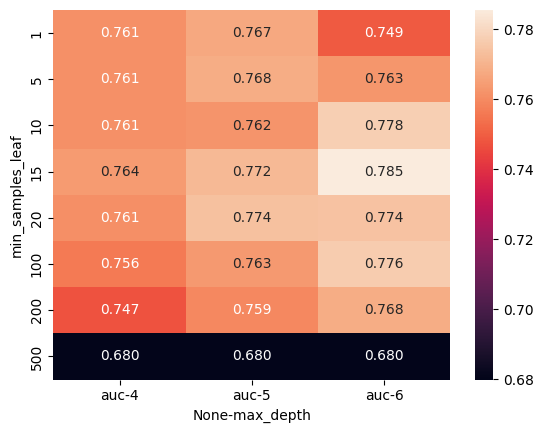

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [49]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [50]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- income <= 117.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  117.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.5 Ensembles and random forest
* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [53]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

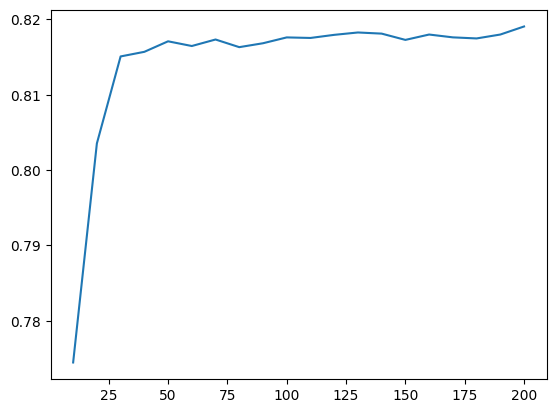

In [54]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [55]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [56]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

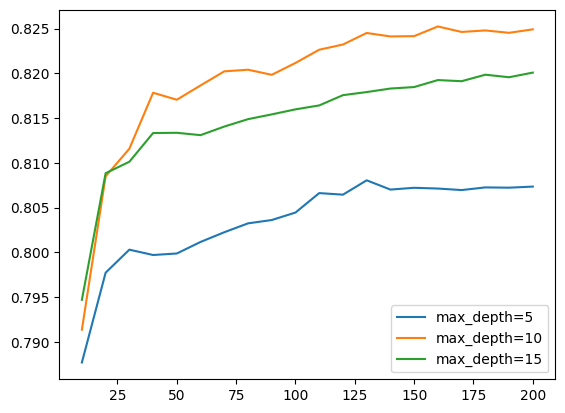

In [57]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [58]:
max_depth = 10

In [59]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [60]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

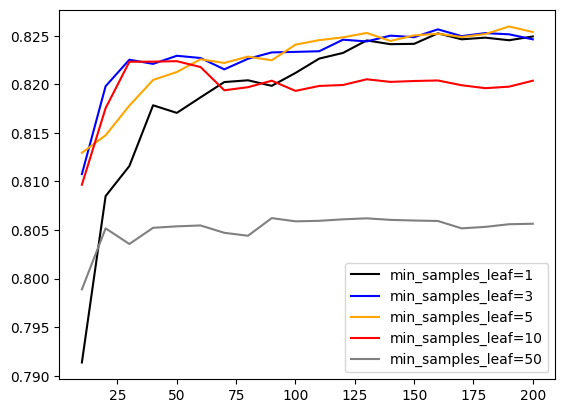

In [61]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [62]:
min_samples_leaf = 3

In [63]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

Other useful parameters:
* max_features
* bootstrap

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.6 Gradient boosting and XGBoost
* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

Unlike Random Forest where each decision tree trains independently, in the Gradient Boosting Trees, the models are combined sequentially where each model takes the prediction errors made by the previous model and then tries to improve the prediction. This process continues to n number of iterations and in the end all the predictions get combined to make final prediction.

XGBoost is one of the libraries which implements the gradient boosting technique. To make use of the library, we need to install with pip install xgboost.

In [65]:
# !pip install xgboost

In [64]:
import xgboost as xgb

To train and evaluate the model, we need to wrap our train and validation data into a special data structure from XGBoost which is called DMatrix. This data structure is optimized to train xgboost models faster.

In [65]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Classes, functions, and methods:

* **xgb.train():** method to train xgboost model.
* **xgb_params:** key-value pairs of hyperparameters to train xgboost model.
* **watchlist:** list to store training and validation accuracy to evaluate the performance of the model after each training iteration. The list takes tuple of train and validation set from DMatrix wrapper, for example, watchlist = [(dtrain, 'train'), (dval, 'val')].
* **%%capture output:** IPython magic command which captures the standard output and standard error of a cell.

In [66]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [67]:
y_pred = model.predict(dval)

In [68]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [70]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [71]:
s = output.stdout

In [72]:
print(s[:200])

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	tr


In [73]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [74]:
df_score = parse_xgb_output(output)

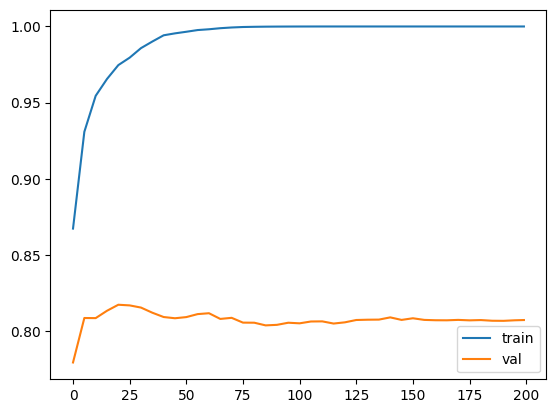

In [75]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

At around 75 iterations, the model starts overfitting (lowest AUC val and AUC train stagning at Max 1)

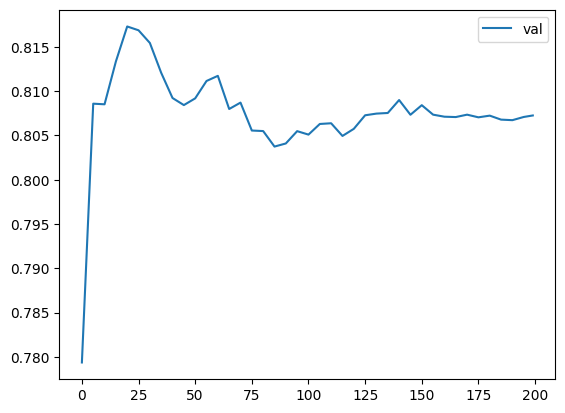

In [76]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

Alternatively you can use the evals_result parameter of the xgb.train(..). You can pass an empty dictionary in for this parameter and the train() method will populate it with the results. The result will be of type OrderedDict so we have to transform it to a dataframe. For this, zip() can help. Here's an example code snippet:

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

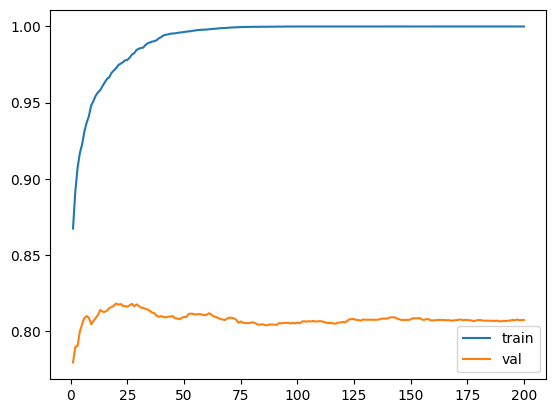

In [77]:
evals_result = {}

model = xgb.train(params=xgb_params,
                  dtrain=dtrain,
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist,
                  evals_result=evals_result)

columns = ['iter', 'train_auc', 'val_auc']
train_aucs = list(evals_result['train'].values())[0]
val_aucs = list(evals_result['val'].values())[0]

df_scores = pd.DataFrame(
    list(zip(
        range(1, len(train_aucs) + 1),
        train_aucs,
        val_aucs
    )), columns=columns)

plt.plot(df_scores.iter, df_scores.train_auc, label='train')
plt.plot(df_scores.iter, df_scores.val_auc, label='val')
plt.legend()

## 6.7 XGBoost parameter tuning
XGBoost has various tunable parameters but the three most important ones are:

* **eta** (default=0.3)
It is also called learning rate and is used to prevent overfitting by regularizing the weights of new features in each boosting step. range: [0, 1]
* **max_depth** (default=6)
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. range: [0, inf]
* **min_child_weight** (default=1)
Minimum number of samples in leaf node. range: [0, inf]

For XGBoost models, there are other ways of finding the best parameters as well but the one we implement here follows the sequence of:

* First find the best value for eta
* Second, find the best value for max_depth
* Third, find the best value for min_child_weight

### 1) eta

In [119]:
scores = {}

In [136]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [137]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [138]:
scores.keys()

dict_keys(['eta=1', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

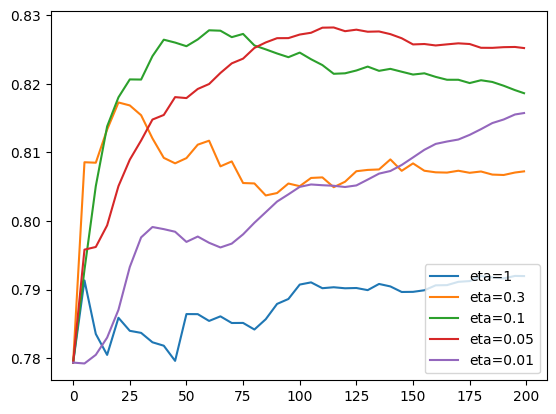

In [139]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

* eta 1.0 is the worst
* eta 0.01 is too slow
* eta 0.3 is intermediate and overfit fast
* eta 0.05 make twice iterations as eta 0.1 for the same result
* eta 0.1 seems the best with a peak at around 65 iterations

### 2) max depth

In [140]:
scores = {}

In [147]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [148]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

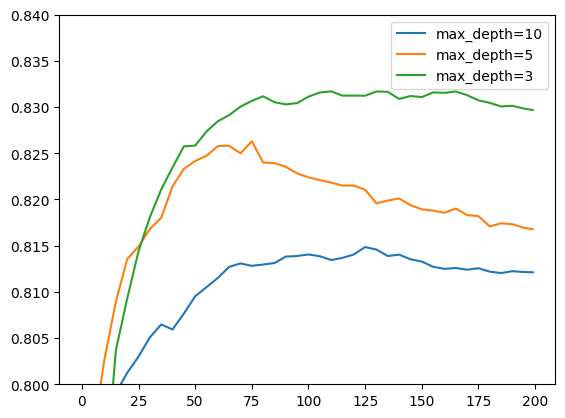

In [149]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

max depth = 3 has the best performance

### 3) min child weight

In [150]:
scores = {}

In [163]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [164]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

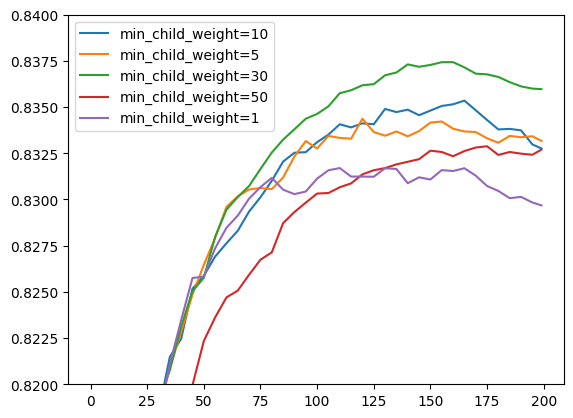

In [165]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

Other useful parameters are: https://xgboost.readthedocs.io/en/latest/parameter.html

* **subsample** (default=1)
Subsample ratio of the training instances. Setting it to 0.5 means that model would randomly sample half of the trianing data prior to growing trees. range: (0, 1]
* **colsample_bytree** (default=1)
This is similar to random forest, where each tree is made with the subset of randomly choosen features.
* **lambda** (default=1)
Also called reg_lambda. L2 regularization term on weights. Increasing this value will make model more conservative.
* **alpha** (default=0)
Also called reg_alpha. L1 regularization term on weights. Increasing this value will make model more conservative.

Final check with the best number of iterations:

In [93]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [94]:
df_scores = parse_xgb_output(output)
df_scores.val_auc.max()

0.83743

In [95]:
max(zip(df_scores.val_auc ,df_scores.num_iter))

(0.83743, 160)

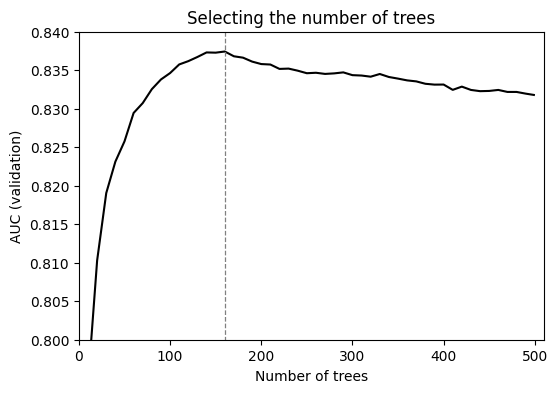

In [96]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.num_iter, df_scores.val_auc, color='black', linestyle='solid')


plt.ylim(0.80, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.84, 9))


plt.vlines(160, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

In [97]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=160)

## 6.8 Selecting the final model
* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

**1) Decision Tree model**

In [98]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [99]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

**2) Random Forest model**

In [102]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [103]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

**3) XGBoost model**

In [104]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=160)

In [105]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8373344070136349

Generally, XGBoost models perform better on tabular data than other machine learning models but the downside is that these model are easy to overfit cause of the high number of hyperparameter. Therefore, XGBoost models require a lot more attention for parameters tuning to optimize them.

In [106]:
df_full_train = df_full_train.reset_index(drop=True)

In [107]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [108]:
del df_full_train['status']

In [109]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [111]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [112]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=160)

In [113]:
y_pred = model.predict(dtest)

In [114]:
roc_auc_score(y_test, y_pred)

0.8314842871804897

## 6.9 Summary
* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

## 6.10 Explore more
* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
* There's a variation of random forest called "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
* XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: subsample and colsample_bytree.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than others. See example here for random forest (it's the same for plain decision trees) and for xgboost
* Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.

## 6.11 Bonus: Feature Importance

## Decision Trees

In [166]:
dt.feature_importances_

array([0.01387723, 0.04793733, 0.1226385 , 0.00833288, 0.0250906 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18724799, 0.00699145, 0.        ,
       0.        , 0.17292753, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0302163 ,
       0.        , 0.24421676, 0.12658146, 0.01394197])

In [167]:
list(zip(dv.feature_names_, dt.feature_importances_))

[('age', 0.013877231876069153),
 ('amount', 0.04793733336664824),
 ('assets', 0.12263850423922844),
 ('debt', 0.008332876385504902),
 ('expenses', 0.025090602575881322),
 ('home=ignore', 0.0),
 ('home=other', 0.0),
 ('home=owner', 0.0),
 ('home=parents', 0.0),
 ('home=private', 0.0),
 ('home=rent', 0.0),
 ('home=unk', 0.0),
 ('income', 0.18724798934476602),
 ('job=fixed', 0.006991445659436667),
 ('job=freelance', 0.0),
 ('job=others', 0.0),
 ('job=partime', 0.17292752964348085),
 ('job=unk', 0.0),
 ('marital=divorced', 0.0),
 ('marital=married', 0.0),
 ('marital=separated', 0.0),
 ('marital=single', 0.0),
 ('marital=unk', 0.0),
 ('marital=widow', 0.0),
 ('price', 0.030216298419676543),
 ('records=no', 0.0),
 ('records=yes', 0.24421675762093445),
 ('seniority', 0.12658145602795504),
 ('time', 0.013941974840418331)]

In [168]:
importances = list(zip(dv.feature_names_, dt.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
26,records=yes,0.244217
12,income,0.187248
16,job=partime,0.172928
27,seniority,0.126581
2,assets,0.122639
1,amount,0.047937
24,price,0.030216
4,expenses,0.025091
28,time,0.013942
0,age,0.013877


In [169]:
df_importance = df_importance[df_importance.gain > 0]

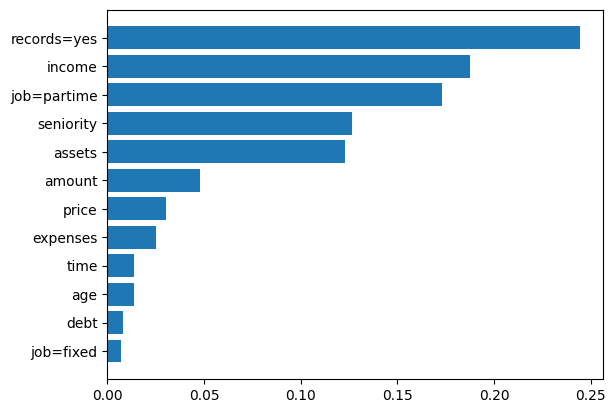

In [170]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

## Random Forest

In [78]:
rf.feature_importances_

array([6.54819080e-02, 8.35196573e-02, 7.70916778e-02, 1.64874636e-02,
       3.97017980e-02, 7.19528435e-05, 6.64923967e-03, 2.24914839e-02,
       1.13396087e-02, 3.31364934e-03, 1.31151064e-02, 0.00000000e+00,
       1.51792620e-01, 3.80781848e-02, 1.08790153e-02, 3.91502618e-03,
       5.65950456e-02, 0.00000000e+00, 5.69385615e-04, 7.87825376e-03,
       2.18600961e-03, 6.51095572e-03, 0.00000000e+00, 5.89178493e-04,
       7.47251780e-02, 8.52482317e-02, 6.30053608e-02, 1.26786571e-01,
       3.19774380e-02])

In [79]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
12,income,0.151793
27,seniority,0.126787
25,records=no,0.085248
1,amount,0.083520
2,assets,0.077092
24,price,0.074725
0,age,0.065482
26,records=yes,0.063005
16,job=partime,0.056595
4,expenses,0.039702


In [80]:
df_importance = df_importance[df_importance.gain > 0.01]

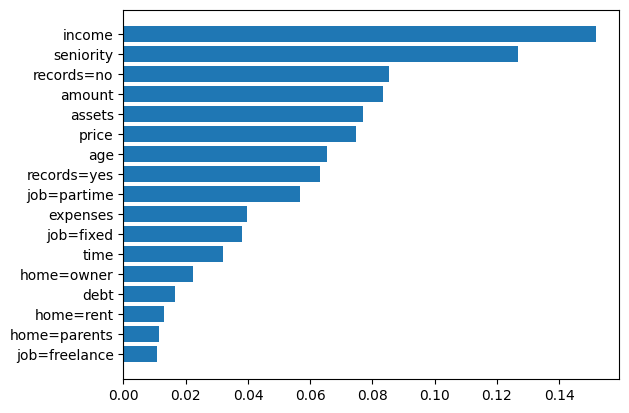

In [81]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

## XGBoost

In [82]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('records=no', 5.512298583984375),
 ('job=partime', 5.0388264656066895),
 ('seniority', 1.404326319694519),
 ('job=fixed', 1.3682732582092285),
 ('assets', 1.2059545516967773),
 ('home=owner', 1.1434202194213867),
 ('marital=separated', 1.0939542055130005),
 ('home=other', 1.0709326267242432),
 ('income', 1.061039686203003),
 ('home=private', 0.9919136166572571),
 ('marital=widow', 0.9750585556030273),
 ('home=rent', 0.9714621901512146),
 ('marital=married', 0.9710981845855713),
 ('amount', 0.8756617903709412),
 ('debt', 0.8747706413269043),
 ('expenses', 0.8397434949874878),
 ('age', 0.7872766852378845),
 ('home=parents', 0.7851710319519043),
 ('time', 0.7843592762947083),
 ('price', 0.7706837058067322),
 ('job=others', 0.6340041160583496),
 ('marital=single', 0.5839042663574219),
 ('job=freelance', 0.5265153050422668)]

In [83]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('price', 889.0),
 ('income', 817.0),
 ('amount', 694.0),
 ('age', 680.0),
 ('seniority', 500.0),
 ('expenses', 421.0),
 ('assets', 418.0),
 ('time', 198.0),
 ('debt', 158.0),
 ('records=no', 94.0),
 ('job=fixed', 77.0),
 ('home=parents', 74.0),
 ('home=rent', 49.0),
 ('job=partime', 46.0),
 ('marital=married', 37.0),
 ('job=freelance', 35.0),
 ('home=owner', 35.0),
 ('marital=single', 33.0),
 ('home=private', 28.0),
 ('job=others', 21.0),
 ('marital=separated', 14.0),
 ('home=other', 14.0),
 ('marital=widow', 1.0)]

In [84]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

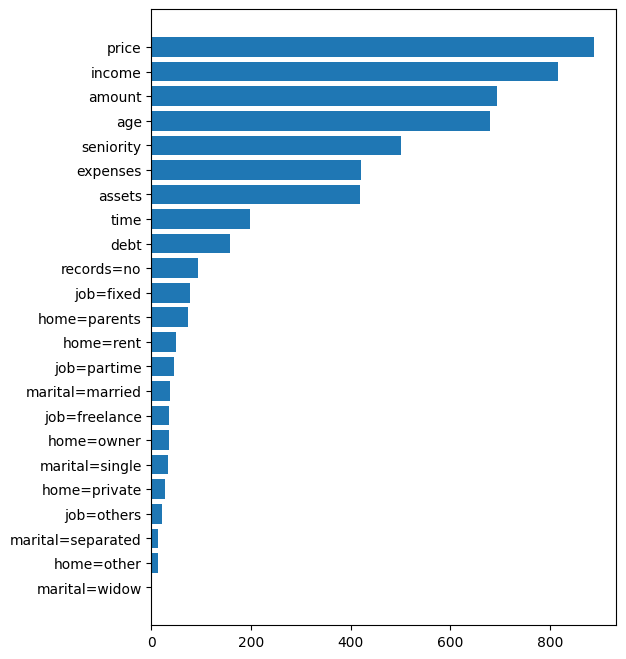

In [85]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

## 6.12 Bonus: Extremely randomized trees
Similar to random forest, but more random. Instead of selecting the best split among all possible splits, ET picks a few candidate splits at random and then select the best one among them.

In [86]:
from sklearn.ensemble import ExtraTreesClassifier

In [87]:
aucs = []

for i in range(10, 201, 10):
    rf = ExtraTreesClassifier(n_estimators=i, max_depth=30)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

10 -> 0.768
20 -> 0.791
30 -> 0.788
40 -> 0.786
50 -> 0.794
60 -> 0.789
70 -> 0.795
80 -> 0.794
90 -> 0.798
100 -> 0.800
110 -> 0.795
120 -> 0.791
130 -> 0.793
140 -> 0.791
150 -> 0.796
160 -> 0.797
170 -> 0.799
180 -> 0.798
190 -> 0.792
200 -> 0.794
